# EXPORTING A MODEL FROM PYTORCH TO ONNX AND RUNNING IT USING ONNX RUNTIME

In [1]:
# Some standard imports
import io
import time
import numpy as np

from torch import nn
import torch.utils.model_zoo as model_zoo
import torch.onnx

##  define model


In [2]:
# Super Resolution model definition in PyTorch
import torch.nn as nn
import torch.nn.init as init


class SuperResolutionNet(nn.Module):
    def __init__(self, upscale_factor, inplace=False):
        super(SuperResolutionNet, self).__init__()

        self.relu = nn.ReLU(inplace=inplace)
        self.conv1 = nn.Conv2d(1, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, upscale_factor ** 2, (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

        self._initialize_weights()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pixel_shuffle(self.conv4(x))
        return x

    def _initialize_weights(self):
        init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv4.weight)

# Create the super-resolution model by using the above model definition.
torch_model = SuperResolutionNet(upscale_factor=3)

In [3]:
# Load pretrained model weights
model_url = 'https://s3.amazonaws.com/pytorch/test_data/export/superres_epoch100-44c6958e.pth'

# Initialize model with the pretrained weights
map_location = lambda storage, loc: storage
if torch.cuda.is_available():
    map_location = None
torch_model.load_state_dict(model_zoo.load_url(model_url, map_location=map_location))

# set the model to inference mode
torch_model.eval()

SuperResolutionNet(
  (relu): ReLU()
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pixel_shuffle): PixelShuffle(upscale_factor=3)
)

## convert to onnx

Exporting a model in PyTorch works via tracing or scripting.

In [4]:
# Input to the model
batch_size = 1    # just a random number
x = torch.randn(batch_size, 1, 224, 224, requires_grad=True)
torch_out = torch_model(x)

# Export the model
torch.onnx.export(torch_model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "super_resolution.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                                'output' : {0 : 'batch_size'}},
                  verbose = True)

graph(%input : Float(1:50176, 1:50176, 224:224, 224:1, requires_grad=1, device=cpu),
      %conv1.weight : Float(64:25, 1:25, 5:5, 5:1, requires_grad=1, device=cpu),
      %conv1.bias : Float(64:1, requires_grad=1, device=cpu),
      %conv2.weight : Float(64:576, 64:9, 3:3, 3:1, requires_grad=1, device=cpu),
      %conv2.bias : Float(64:1, requires_grad=1, device=cpu),
      %conv3.weight : Float(32:576, 64:9, 3:3, 3:1, requires_grad=1, device=cpu),
      %conv3.bias : Float(32:1, requires_grad=1, device=cpu),
      %conv4.weight : Float(9:288, 32:9, 3:3, 3:1, requires_grad=1, device=cpu),
      %conv4.bias : Float(9:1, requires_grad=1, device=cpu)):
  %9 : Float(1:3211264, 64:50176, 224:224, 224:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[5, 5], pads=[2, 2, 2, 2], strides=[1, 1]](%input, %conv1.weight, %conv1.bias) # /home/alex/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/modules/conv.py:420:0
  %10 : Float(1:3211264, 64:50176, 

In [5]:
! ls -a

.			  demo		      Planet_EDA.ipynb
..			  f_score.py	      pr_curve.py
confusion_matrix.py	  graph		      roc_curve.py
custom_bce_ce_loss.ipynb  .ipynb_checkpoints  super_resolution.onnx
custom_bce_ce_loss.py	  onnx_demo.ipynb


## check model

In [6]:
import onnx

# load onnx model
onnx_model = onnx.load("super_resolution.onnx")
# verify the model’s structure and confirm that the model has a valid schema.
onnx.checker.check_model(onnx_model)

## ompute the output using ONNX Runtime

In [7]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("super_resolution.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

## Running the model on an image using ONNX Runtime

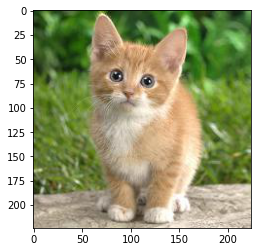

tensor([[[[0.2157, 0.1961, 0.1922,  ..., 0.5294, 0.5569, 0.5725],
          [0.2039, 0.1922, 0.1922,  ..., 0.5333, 0.5529, 0.5686],
          [0.2000, 0.1843, 0.1843,  ..., 0.5216, 0.5373, 0.5490],
          ...,
          [0.6667, 0.6745, 0.6392,  ..., 0.6902, 0.6667, 0.6078],
          [0.6392, 0.6431, 0.6235,  ..., 0.8000, 0.7608, 0.6745],
          [0.6392, 0.6353, 0.6510,  ..., 0.8118, 0.7686, 0.6667]]]])

In [8]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


img = Image.open("./demo/cat.jpg")
plt.imshow(img)
plt.show()

resize = transforms.Resize([224, 224])
img = resize(img)

img_ycbcr = img.convert('YCbCr')
img_y, img_cb, img_cr = img_ycbcr.split()

to_tensor = transforms.ToTensor()
img_y = to_tensor(img_y)
img_y.unsqueeze_(0)

In [9]:
start_time = time.perf_counter()
torch_out = torch_model(img_y)
torch_cost_time = time.perf_counter() - start_time

start_time = time.perf_counter()
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(img_y)}
ort_outs = ort_session.run(None, ort_inputs)
onnx_cost_time = time.perf_counter() - start_time

img_out_y = ort_outs[0]

print('pytorch cost time {}'.format(torch_cost_time))
print('onnx_cost_time {}'.format(onnx_cost_time))

pytorch cost time 0.03178320999722928
onnx_cost_time 0.01861082500545308


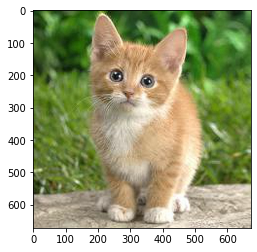

In [10]:
img_out_y = Image.fromarray(np.uint8((img_out_y[0] * 255.0).clip(0, 255)[0]), mode='L')

# get the output image follow post-processing step from PyTorch implementation
final_img = Image.merge(
    "YCbCr", [
        img_out_y,
        img_cb.resize(img_out_y.size, Image.BICUBIC),
        img_cr.resize(img_out_y.size, Image.BICUBIC),
    ]).convert("RGB")

# Save the image, we will compare this with the output image from mobile device
final_img.save("./demo/cat_superres_with_ort.jpg")
plt.imshow(final_img)
plt.show()